# Interpretability 2, from Local to Global explanations with SHAP — SHapley Additive exPlanations
## Local explanations: explaining one prediction
SHAP explains the prediction for a *single* input sample \(x\) by decomposing the model output into **feature contributions**:

\begin{equation}
f(x) = \phi_0 + \sum_{i=1}^{M}\phi_i
\end{equation}

Where:
-$f(x)$ is the model output (e.g. probability of class 1)
- $\phi_0$ is the **baseline** prediction (expected model output over a reference dataset)
- $\phi_i$ is the **contribution** of feature $i$ for this specific sample

Interpretation:
- $\phi_i > 0$: feature $i$ pushes the prediction **up**
- $\phi_i < 0$: feature $i$ pushes the prediction **down**
- the contributions sum exactly to the prediction (**additivity**)

## Why Shapley values?
SHAP is based on **Shapley values** from cooperative game theory.

Each feature as a “player” in a game, and the prediction \(f(x)\) as the “payout”.
Shapley

In [27]:
!pip install shap

In [28]:
# If needed, install dependencies
# !pip install shap
import numpy as np
import pandas as pd
import shap
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

shap.initjs()

# 03 — CMB-inspired ML Example: Classifying Power Spectra

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    roc_auc_score,
)

rng = np.random.default_rng(42)

plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True

In [30]:
# Multipole grid
ell_min, ell_max = 2, 2000
ells = np.arange(ell_min, ell_max + 1)

len(ells)

1999

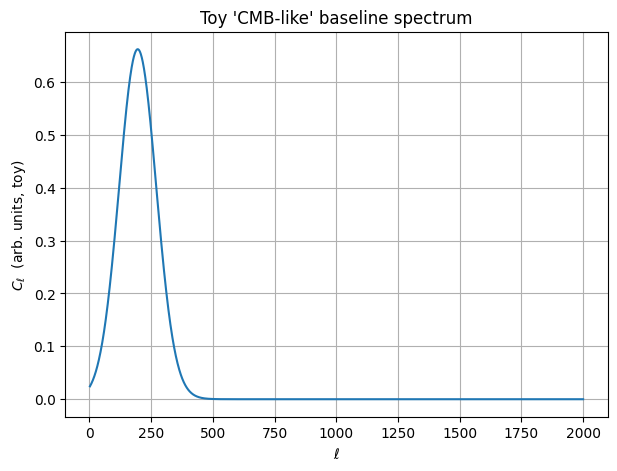

In [31]:
def baseline_cl(ell, A=1.0, l_peak=220.0, width_peak=80.0, damping_scale=1500.0):
    """
    Toy 'CMB-like' angular power spectrum:
    - broad acoustic peak
    - decaying tail
    """
    # Broad first peak
    peak = np.exp(-0.5 * ((ell - l_peak) / width_peak) ** 2)
    # Some gentle wiggles (very crude multi-peak feel)
    wiggles = 0.4 * np.cos(ell / 150.0) + 0.6
    # Damping at high ell
    damping = np.exp(-(ell / damping_scale) ** 2)
    cl = A * peak * wiggles * damping
    # Avoid zeros
    return cl + 1e-8

cl_base = baseline_cl(ells)
plt.plot(ells, cl_base)
plt.xlabel(r"$\ell$")
plt.ylabel(r"$C_\ell$  (arb. units, toy)")
plt.title("Toy 'CMB-like' baseline spectrum")
plt.show()

In [32]:
def add_local_feature(cl, ell, amp=0.25, l0=500.0, width=80.0, freq=0.15):
    """
    Multiply baseline Cl by a localized oscillatory feature around ell ~ l0.

    cl_new = cl * (1 + amp * bump),
    where bump is a Gaussian envelope times a sinusoid in ell.
    """
    envelope = np.exp(-0.5 * ((ell - l0) / width) ** 2)
    oscill = np.sin(freq * (ell - l0))
    bump = envelope * oscill
    return cl * (1.0 + amp * bump)

cl_feat = add_local_feature(cl_base, ells, amp=0.3, l0=500.0, width=70.0, freq=0.18)

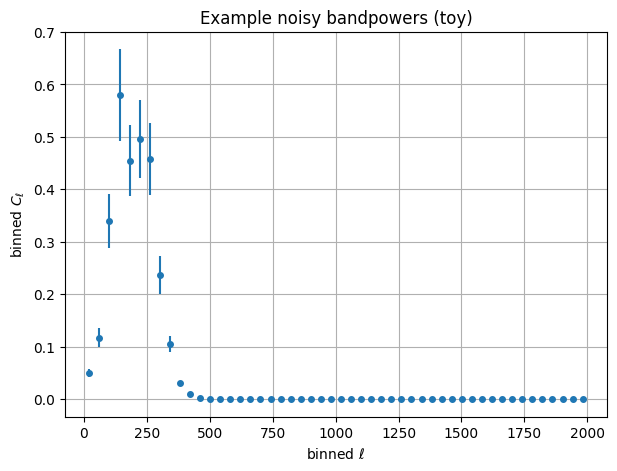

In [33]:
def bin_cl(ell, cl, nbins=50):
    """
    Bin C_ell into nbins approximately equal in ell.
    Returns bandpower centers and averaged C_ell in each bin.
    """
    indices = np.array_split(np.arange(len(ell)), nbins)
    cl_binned = np.array([cl[idx].mean() for idx in indices])
    ell_centers = np.array([ell[idx].mean() for idx in indices])
    return ell_centers, cl_binned

def noisy_bandpower_realization(ell, cl_theory, frac_noise=0.1, nbins=50):
    """
    From a theoretical spectrum, create a noisy binned spectrum.
    frac_noise is a fractional Gaussian noise level.
    """
    ell_c, cl_b = bin_cl(ell, cl_theory, nbins=nbins)
    noise = rng.normal(0.0, frac_noise * cl_b)
    cl_obs = cl_b + noise
    # Ensure positivity
    cl_obs = np.clip(cl_obs, 1e-8, None)
    return ell_c, cl_obs

# Quick test
ell_c_test, cl_obs_test = noisy_bandpower_realization(ells, cl_base, frac_noise=0.15)
plt.errorbar(ell_c_test, cl_obs_test, yerr=0.15*cl_obs_test, fmt="o", ms=4)
plt.xlabel(r"binned $\ell$")
plt.ylabel(r"binned $C_\ell$")
plt.title("Example noisy bandpowers (toy)")
plt.show()

In [34]:
N = 2000             #total number of spectra
nbins = 150           #bandpowers per spectrum
frac_noise = 0.02    #fractional noise level

X = []
y = []
ell_centers = None

for i in range(N):
    #Randomize some baseline parameters slightly
    A = rng.uniform(0.9, 1.1)
    l_peak = rng.uniform(200.0, 240.0)
    width_peak = rng.uniform(60.0, 100.0)
    damping = rng.uniform(1300.0, 1800.0)

    cl0 = baseline_cl(ells, A=A, l_peak=l_peak,
                      width_peak=width_peak, damping_scale=damping)

    if rng.random() < 0.5:
        #Class 0: "ΛCDM-like" (no extra feature)
        cl_theory = cl0
        label = 0
    else:
        #Class 1: baseline + feature with random location & amplitude
        amp = rng.uniform(0.6, 1.2)
        l0_feat = rng.normal(600.0, 30.0)     # concentrated around ~600
        width_feat = rng.uniform(50.0, 80.0)
        freq_feat = rng.uniform(0.14, 0.20)
        cl_featured = add_local_feature(
            cl0, ells,
            amp=amp, l0=l0_feat,
            width=width_feat, freq=freq_feat
        )
        cl_theory = cl_featured
        label = 1

    ell_c, cl_obs = noisy_bandpower_realization(
        ells, cl_theory, frac_noise=frac_noise, nbins=nbins
    )
    if ell_centers is None:
        ell_centers = ell_c  # store once

    X.append(cl_obs)
    y.append(label)

X = np.array(X)
y = np.array(y)


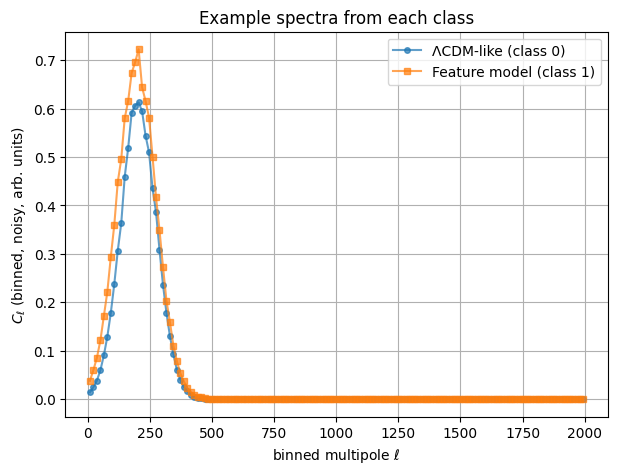

In [35]:
def plot_example_spectra(X, y, ell_c, n_per_class=3):
    plt.figure(figsize=(7, 5))
    classes = [0, 1]
    labels = ["ΛCDM-like (class 0)", "Feature model (class 1)"]
    markers = ["o", "s"]

    for cls, lab, mk in zip(classes, labels, markers):
        idx = np.where(y == cls)[0]
        idx = rng.choice(idx, size=min(n_per_class, 1), replace=False)
        for j in idx:
            plt.plot(ell_c, X[j], marker=mk, ms=4, alpha=0.7, label=lab if j == idx[0] else None)

    plt.xlabel(r"binned multipole $\ell$")
    plt.ylabel(r"$C_\ell$ (binned, noisy, arb. units)")
    plt.title("Example spectra from each class")
    plt.legend()
    plt.show()

plot_example_spectra(X, y, ell_centers)


In [36]:
import numpy as np
rng = np.random.default_rng(0)

ells = np.arange(2, 2000)

def baseline_cl(ells, A=1.0, ns=0.965):
    ell0 = 80.0
    cl = A * (ells / ell0) ** (ns - 1.0) * np.exp(-(ells / 1800.0) ** 2)
    return cl

def add_feature_simple(cl, ells, amp=0.05, ell_min=300, ell_max=700):
    """Very simple feature: boost power by (1+amp) in a contiguous ell range."""
    cl_feat = cl.copy()
    mask = (ells >= ell_min) & (ells <= ell_max)
    cl_feat[mask] *= (1.0 + amp)
    return cl_feat

def noisy_bandpowers(cl, frac_noise=0.05, nbins=30):
    indices = np.array_split(np.arange(len(cl)), nbins)
    bp = np.array([cl[idx].mean() for idx in indices])
    bp = bp * (1.0 + rng.normal(0.0, frac_noise, size=bp.size))
    return bp

def generate_dataset(N=3000, nbins=50):
    X, y = [], []
    for i in range(N):
        cl_base = baseline_cl(ells, A=1.0, ns=0.965)

        if rng.random() < 0.5:
            #Class 0: pure baseline
            cl = cl_base
            label = 0
        else:
            #Class 1: baseline with a big fat bump between ell=300 and 700
            cl = add_feature_simple(cl_base, ells, amp=0.01,
                                    ell_min=300, ell_max=700)
            label = 1

        bp = noisy_bandpowers(cl, frac_noise=0.01, nbins=nbins)
        X.append(np.log(bp + 1e-6))
        y.append(label)

    return np.array(X), np.array(y)

X, y = generate_dataset()
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))


X shape: (3000, 50)
Class counts: (array([0, 1]), array([1525, 1475]))


In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=45
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=45
)

X_train.shape, X_val.shape

((1680, 50), (420, 50))

In [38]:
import tensorflow as tf
tf.keras.backend.clear_session()  #Clear previous models from memory

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]

def make_cmb_classifier():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(1, activation="sigmoid")  #binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_cmb_classifier()
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,329 (13.00 KB)

 Trainable params: 3,329 (13.00 KB)

 Non-trainable params: 0 (0.00 B)

In [40]:
epochs = 200
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.5019 - loss: 0.6954 - val_accuracy: 0.5167 - val_loss: 0.6885
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5073 - loss: 0.6945 - val_accuracy: 0.4833 - val_loss: 0.6887
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5615 - loss: 0.6878 - val_accuracy: 0.4833 - val_loss: 0.6989
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5250 - loss: 0.6942 - val_accuracy: 0.4833 - val_loss: 0.6946
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5051 - loss: 0.6914 - val_accuracy: 0.4833 - val_loss: 0.6893
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5028 - loss: 0.6912 - val_accuracy: 0.5167 - val_loss: 0.6816
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5269 - loss: 0.6810 - val_accuracy: 0.4833 - val_loss: 0.6838
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5677 - loss: 0.6856 - val_accuracy: 0.5167 - 

Validation accuracy: 0.911


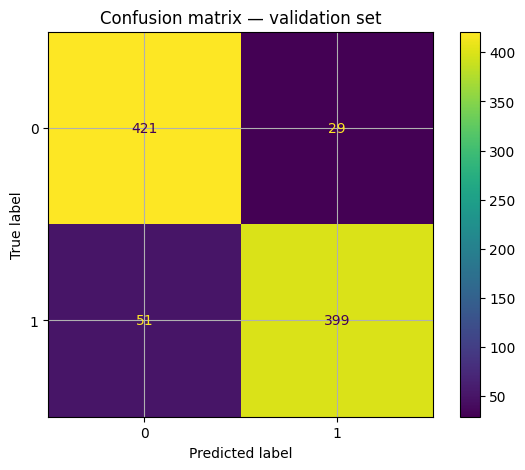

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_test_pred = predict_labels(model, X_test)

acc_val = accuracy_score(y_test, y_test_pred)
print(f"Validation accuracy: {acc_val:.3f}")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix — validation set")
plt.show()

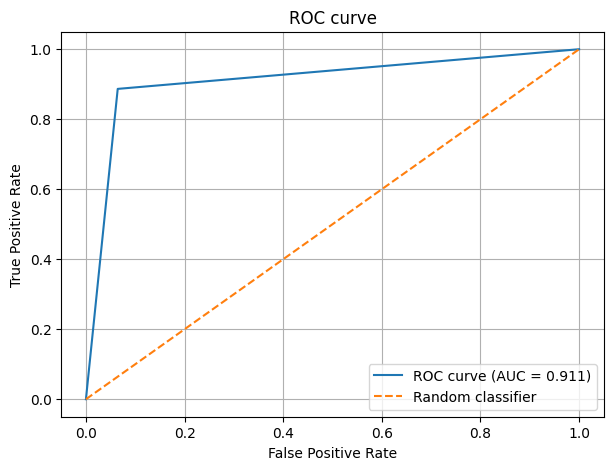

AUC: 0.9111111111111111


In [42]:
from sklearn.metrics import (
    confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

fpr, tpr, roc_thresholds = roc_curve(y_test, y_test_pred)
auc = roc_auc_score(y_test, y_test_pred)

plt.plot(fpr, tpr, label=f"ROC curve (AUC = {auc:.3f})")
plt.plot([0, 1], [0, 1], "--", label="Random classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve")
plt.legend()
plt.show()

print("AUC:", auc)

## 2. Compute SHAP values
For tree-based models, we can use **TreeExplainer**, which is very fast.

For classification, SHAP returns contributions per class. Here we explain class **1**.

In [43]:
#Format fixing
X_train_np = np.asarray(X_train, dtype=np.float32)
X_test_np  = np.asarray(X_test, dtype=np.float32)

print("X_train_np:", X_train_np.shape)
print("X_test_np:", X_test_np.shape)

assert X_train_np.ndim == 2 and X_train_np.shape[1] == 50
assert X_test_np.ndim == 2 and X_test_np.shape[1] == 50

X_train_np: (1680, 50)
X_test_np: (900, 50)


# Global interpretability
We can summarize the model behavior over many samples.

### SHAP summary plot
- Each point is a sample
- Color encodes feature value
- Horizontal axis is SHAP value (impact on prediction)

In [44]:
#Select a small background set (important!)
#Use e.g. 50-200 examples (randomly) from training data
background = X_train_np[np.random.choice(X_train_np.shape[0], 100, replace=False)]
X_explain = X_test_np[:50]
#explain: small batch first
X_explain = np.asarray(X_explain).reshape(X_explain.shape[0], 50)

explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(X_explain)

#For binary classification, shap_values can be a list with one element
sv = shap_values[0] if isinstance(shap_values, list) else shap_values
print("sv shape:", sv.shape)

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=['Tensor(shape=(50, 50))']
  warnings.warn(msg)


sv shape: (50, 50, 1)


In [45]:
base = model.predict(background).mean()
print("baseline =", base)
print("min pred =", model.predict(background, verbose=0).min())
print("max pred =", model.predict(background, verbose=0).max())

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
baseline = 0.5029022
min pred = 0.00035896563
max pred = 0.9996101


sv2 shape: (50, 50)


/tmp/ipython-input-3628174948.py:5: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(sv2, X_explain, feature_names=feature_names)


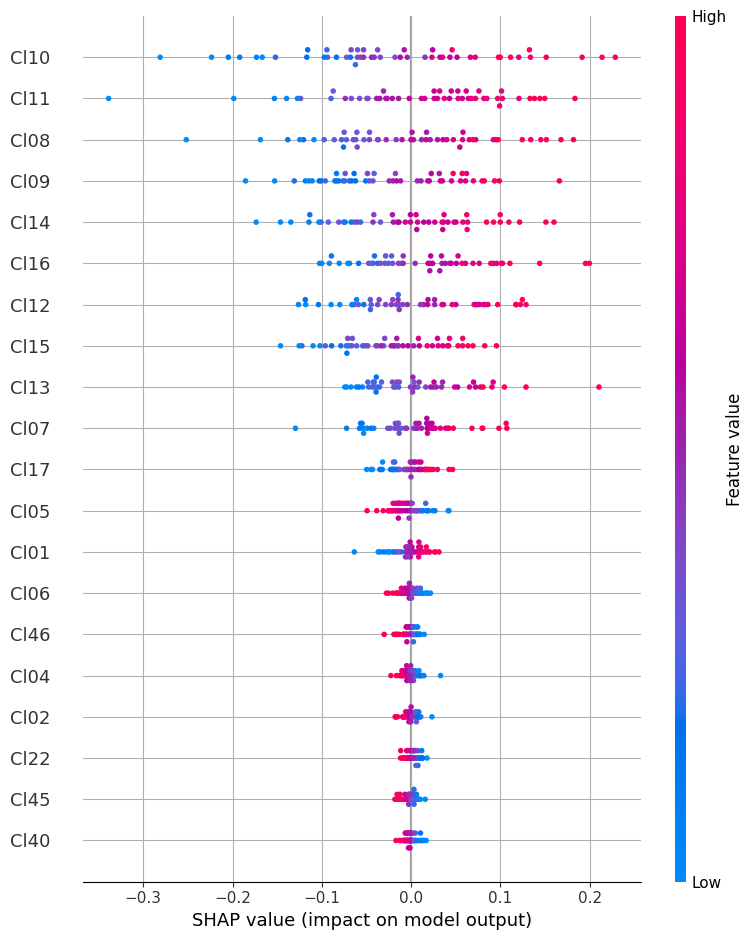

In [46]:
feature_names = [f"Cl{i:02d}" for i in range(50)]
sv2 = np.squeeze(sv, axis=-1)   #(50, 50, 1) -> (50, 50)
print("sv2 shape:", sv2.shape)

shap.summary_plot(sv2, X_explain, feature_names=feature_names)

/tmp/ipython-input-3440574566.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


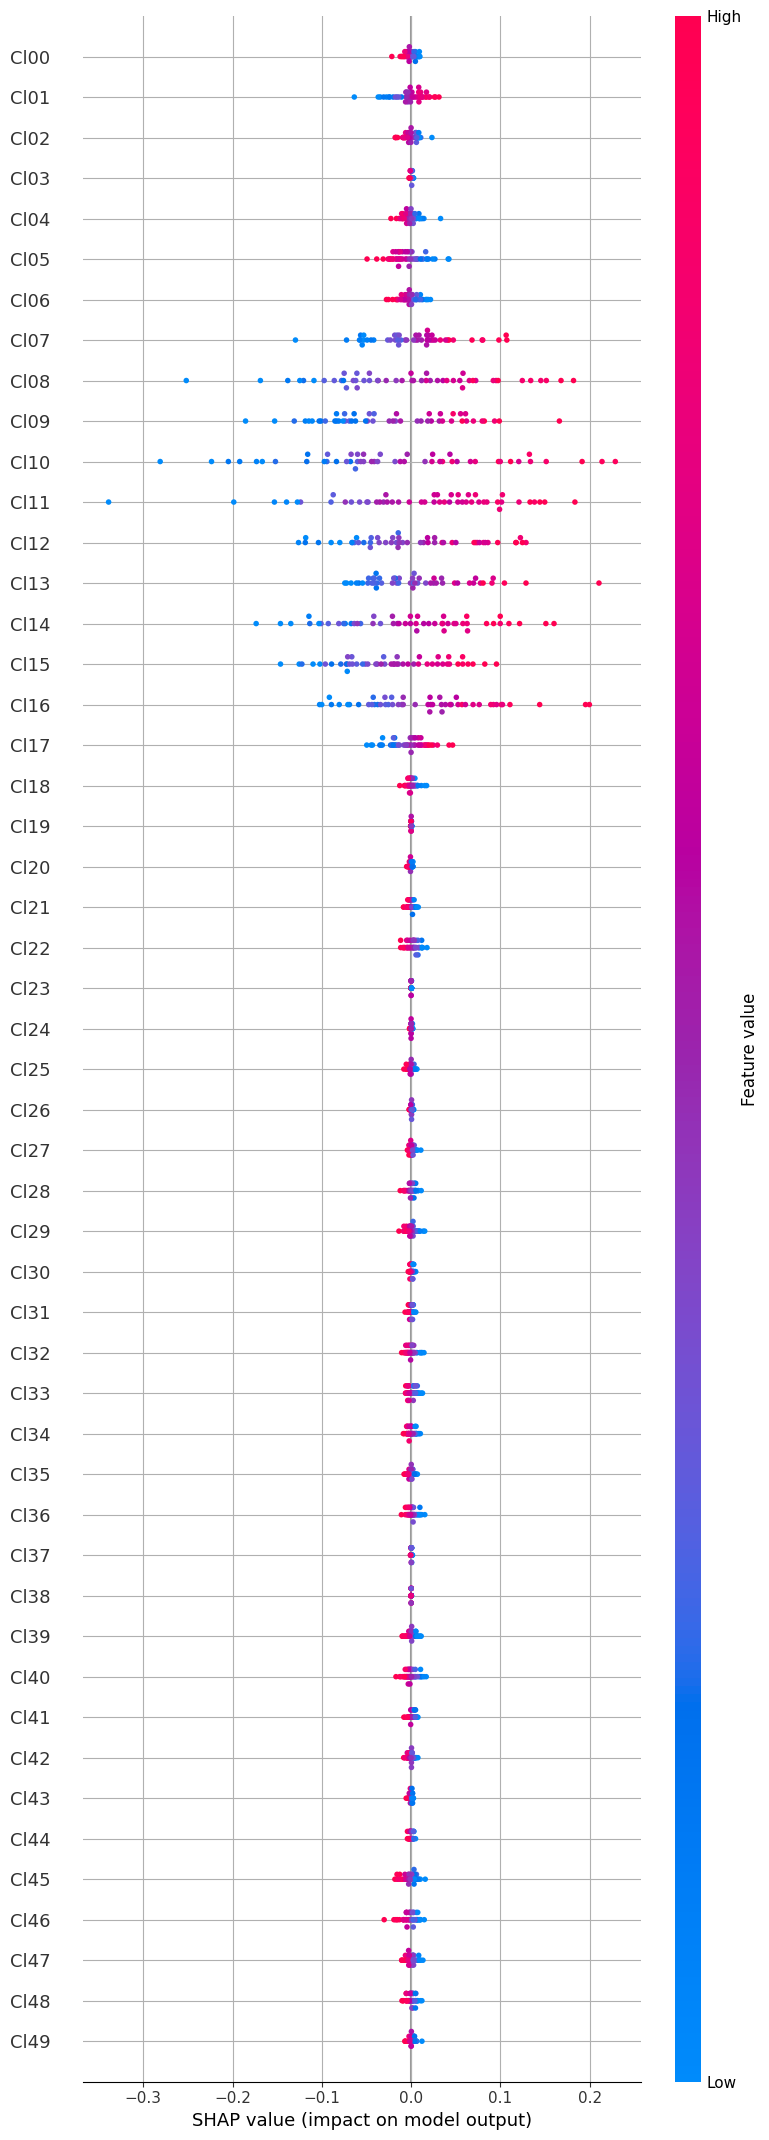

In [47]:
shap.summary_plot(
    sv2,
    X_explain,
    feature_names=feature_names,
    sort=False,
    max_display=50
)

/tmp/ipython-input-656204282.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


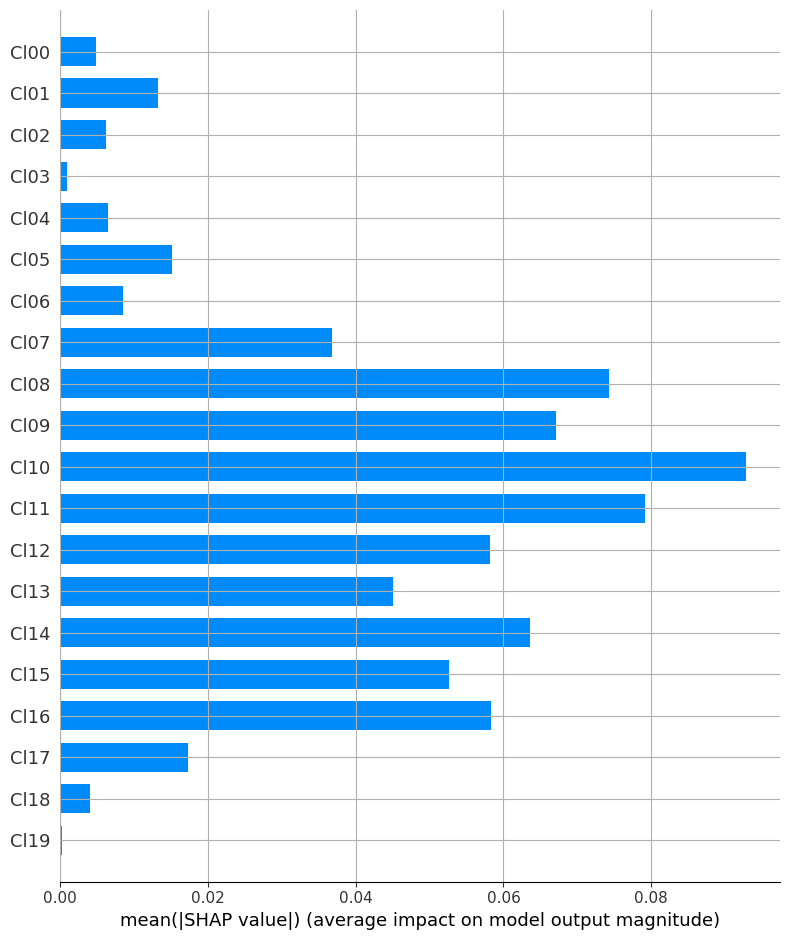

In [48]:
shap.summary_plot(
    sv2,
    X_explain,
    feature_names=feature_names,
    plot_type="bar",
    sort=False
)

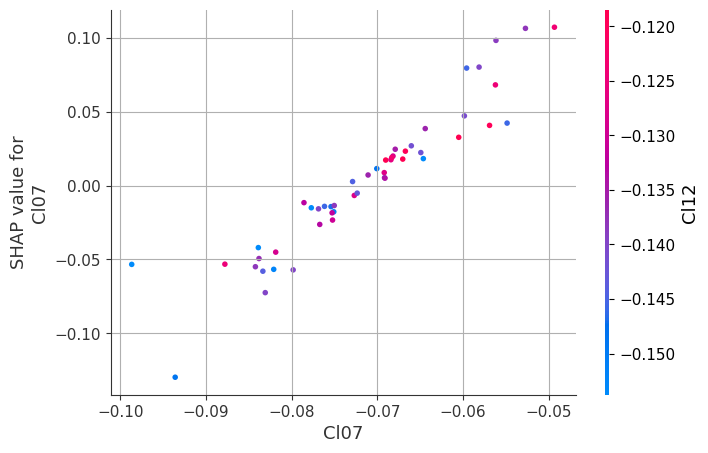

In [49]:
shap.dependence_plot("Cl07", sv2, X_explain,
                     feature_names=feature_names,
                     interaction_index="Cl12")

# your turn!

dataset

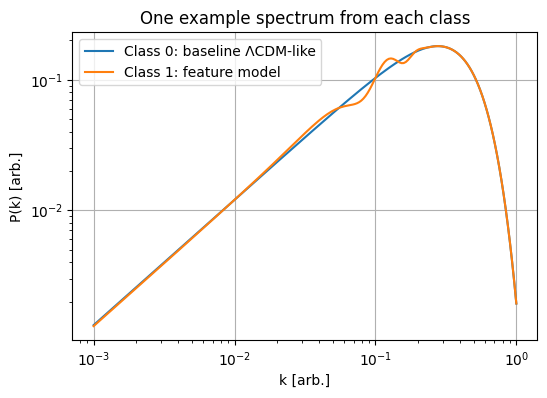

X shape: (3000, 200)
Class counts: (array([0, 1]), array([1504, 1496]))


In [50]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

rng = np.random.default_rng(0)
tf.random.set_seed(0)

plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True

# k grid (log-spaced)
k = np.logspace(-3, 0, 200)  # from 1e-3 to 1

def pk_baseline(k, A=1.0, ns=0.96, k_damp=0.4):
    """
    Toy ΛCDM-like matter power spectrum:
    - power-law tilt with ns
    - exponential small-scale damping
    """
    pk = A * (k ** ns) * np.exp(-(k / k_damp)**2)
    return pk

def pk_feature_model(k, A=1.0, ns=0.96, k_damp=0.4,
                     amp=0.2, k0=0.1, width=0.05, freq=70):
    """
    Toy "feature model": baseline P(k) times a localized oscillatory feature.
    """
    pk0 = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
    bump = np.exp(-0.5*((k - k0)/width)**2) * np.sin(freq*(k-k0))
    return pk0 * (1.0 + amp*bump)

pk0 = pk_baseline(k)
pk1 = pk_feature_model(k)

plt.plot(k, pk0, label="Class 0: baseline ΛCDM-like")
plt.plot(k, pk1, label="Class 1: feature model")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("k [arb.]")
plt.ylabel("P(k) [arb.]")
plt.title("One example spectrum from each class")
plt.legend()
plt.show()

def generate_dataset(N=3000, noise_frac=0.05):
    X, y = [], []

    for i in range(N):
        # small baseline parameter variations
        A = rng.uniform(0.9, 1.1)
        ns = rng.uniform(0.92, 1.0)
        k_damp = rng.uniform(0.3, 0.6)

        if rng.random() < 0.5:
            pk = pk_baseline(k, A=A, ns=ns, k_damp=k_damp)
            label = 0
        else:
            amp = rng.uniform(0.15, 0.3)
            k0 = rng.uniform(0.06, 0.18)
            width = rng.uniform(0.02, 0.06)
            freq = rng.uniform(40, 90)

            pk = pk_feature_model(k, A=A, ns=ns, k_damp=k_damp,
                                  amp=amp, k0=k0, width=width, freq=freq)
            label = 1

        # multiplicative noise
        pk_obs = pk * (1.0 + rng.normal(0.0, noise_frac, size=pk.size))

        # log transform to compress dynamic range
        X.append(np.log(pk_obs + 1e-12))
        y.append(label)

    return np.array(X), np.array(y)

X, y = generate_dataset(N=3000, noise_frac=0.05)
print("X shape:", X.shape)
print("Class counts:", np.unique(y, return_counts=True))

Lime

In [51]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=f476febfdea1c3d578d9ae3ab733df621bd4b0d226c27ea4b9139b62de15ab8c
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [52]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=45
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=45
)

X_train.shape, X_val.shape

((1680, 200), (420, 200))

In [53]:
import tensorflow as tf
tf.keras.backend.clear_session()  #Clear previous models from memory

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

input_dim = X_train.shape[1]

def make_cmb_classifier():
    model = Sequential([
        Dense(64, activation="relu", input_shape=(input_dim,)),
        Dense(1, activation="sigmoid")  #binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = make_cmb_classifier()
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
epochs = 200
batch_size = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

print("Final training accuracy:", history.history["accuracy"][-1])
print("Final validation accuracy:", history.history["val_accuracy"][-1])

Epoch 1/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4957 - loss: 0.8870 - val_accuracy: 0.5429 - val_loss: 0.6874
Epoch 2/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5013 - loss: 0.7494 - val_accuracy: 0.4905 - val_loss: 0.6970
Epoch 3/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5088 - loss: 0.7498 - val_accuracy: 0.4905 - val_loss: 0.7034
Epoch 4/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5075 - loss: 0.7495 - val_accuracy: 0.4905 - val_loss: 0.6979
Epoch 5/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5083 - loss: 0.7477 - val_accuracy: 0.5000 - val_loss: 0.6896
Epoch 6/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5035 - loss: 0.7446 - val_accuracy: 0.5548 - val_loss: 0.6872
Epoch 7/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5068 - loss: 0.7410 - val_accuracy: 0.5667 - val_loss: 0.6866
Epoch 8/200
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4988 - loss: 0.7373 - val_accuracy: 0.5619 - v

Validation accuracy: 0.611


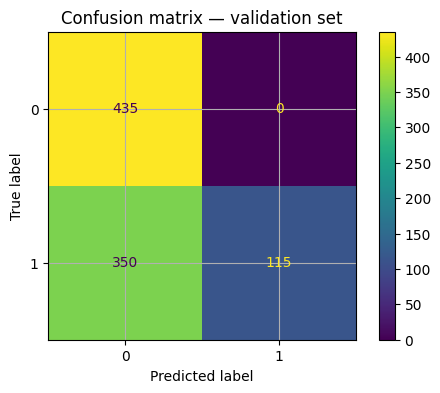

In [60]:
#metrics

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def predict_labels(model, X):
    proba = model.predict(X, verbose=0)
    return (proba > 0.5).astype(int).ravel()

y_test_pred = predict_labels(model, X_test)

acc_val = accuracy_score(y_test, y_test_pred)
print(f"Validation accuracy: {acc_val:.3f}")

cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.title("Confusion matrix — validation set")
plt.show()

In [59]:
def predict_proba_lime(z):
    """
    z: numpy array of shape (n_samples, n_features)
    returns: numpy array of shape (n_samples, 2) with rows summing to 1
    """
    p1 = model.predict(z, verbose=0).reshape(-1)   # P(class=1)
    p1 = np.clip(p1, 1e-6, 1 - 1e-6)               # numerical safety
    p0 = 1.0 - p1
    return np.column_stack([p0, p1])

from lime.lime_tabular import LimeTabularExplainer
from IPython.display import HTML

feature_names = [f"Cl_{i}" for i in range(X_train.shape[1])]

explainer = LimeTabularExplainer(
    training_data=X_train,
    feature_names=feature_names,
    class_names=["LCDM", "Features"],
    mode="classification",
    discretize_continuous=False
)

idx = 10
x0 = X_test[idx]

print("True label:", y_test[idx])
print("Predicted probabilities [LCDM, Features]:", predict_proba_lime(x0.reshape(1, -1))[0])

exp = explainer.explain_instance(
    data_row=x0,
    predict_fn=predict_proba_lime,
    num_features=15,
    num_samples=5000
)

#exp.show_in_notebook(show_table=True)
HTML(exp.as_html())

True label: 0
Predicted probabilities [LCDM, Features]: [0.57510936 0.4248906 ]


Shap!

In [ ]:
#Format fixing
X_train_np = np.asarray(X_train, dtype=np.float32)
X_test_np  = np.asarray(X_test, dtype=np.float32)

print("X_train_np:", X_train_np.shape)
print("X_test_np:", X_test_np.shape)

assert X_train_np.ndim == 2 and X_train_np.shape[1] == 50
assert X_test_np.ndim == 2 and X_test_np.shape[1] == 50
